In [1]:
pip install Tensorflow

  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install keras==2.9

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.9.0 which is incompatible.


  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0


In [3]:
pip install SimpleITK

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opevcv-python

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement opevcv-python (from versions: none)
ERROR: No matching distribution found for opevcv-python


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import SimpleITK as sitk 
from tqdm import tqdm
import numpy as np
%pylab inline

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans


from keras.utils.np_utils import to_categorical,normalize
from keras.models import Model
from keras.layers import MaxPooling2D,add,Input,Dropout,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda,PReLU,concatenate,Lambda
from keras.optimizers import SGD,Adam,RMSprop,Nadam
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from keras import regularizers
from keras import backend as K

from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [6]:
import os
for dirname, _, filenames in os.walk("C:/NewDataset"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_flair.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_seg.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_t1.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
C:/NewDataset\BraTS20_Training_001\BraTS20_Training_001_t2.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_flair.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_seg.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_t1.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_t1ce.nii
C:/NewDataset\BraTS20_Training_002\BraTS20_Training_002_t2.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_flair.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_seg.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_t1.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_t1ce.nii
C:/NewDataset\BraTS20_Training_003\BraTS20_Training_003_t2.nii
C:/NewDataset\BraTS20_Training_004\Br

In [7]:
path = "C:/NewDataset/"

In [12]:
def load_data(path):
    my_dir = sorted(os.listdir(path))
    data = []
    gt = []
    for p in tqdm(my_dir):
        data_list = sorted(os.listdir(path+p))
        
        img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
        flair = sitk.GetArrayFromImage(img_itk)
        flair = flair[30:120,30:222,30:222].reshape([-1,192,192])
        
        img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
        seg =  sitk.GetArrayFromImage(img_itk)
        seg = seg[30:120,30:222,30:222].reshape([-1,192,192])
        
        img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])
        t1 =  sitk.GetArrayFromImage(img_itk)
        t1 = t1[30:120,30:222,30:222].reshape([-1,192,192])
        

        img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
        t1ce =  sitk.GetArrayFromImage(img_itk)
        t1ce = t1ce[30:120,30:222,30:222].reshape([-1,192,192])

        img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
        t2 =  sitk.GetArrayFromImage(img_itk)
        
        t2 = t2[30:120,30:222,30:222].reshape([-1,192,192])

        data.append([flair,t1,t1ce,t2])
        gt.append(seg)
    data = np.asarray(data,dtype=np.float32)
    gt = np.asarray(gt,dtype=np.uint8)
    return data,gt

In [15]:
#HGG
data,gt = load_data(path)

100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


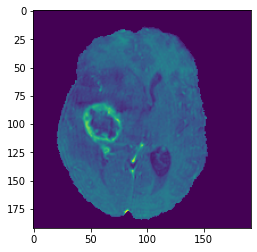

In [16]:
plt.imshow(data[0,2,42,:,:])
plt.show()

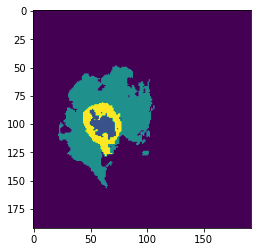

In [17]:
plt.imshow(gt[0,42,:,:])
plt.show()

In [18]:
data = np.transpose(data,(0,2,3,4,1))

In [19]:
data.shape,gt.shape,data.dtype,gt.dtype

((50, 90, 192, 192, 4), (50, 90, 192, 192), dtype('float32'), dtype('uint8'))

In [20]:
data = data.reshape([-1,192,192,4])
gt = gt.reshape([-1,192,192,1])

In [21]:
data.shape,gt.shape,data.dtype,gt.dtype

((4500, 192, 192, 4), (4500, 192, 192, 1), dtype('float32'), dtype('uint8'))

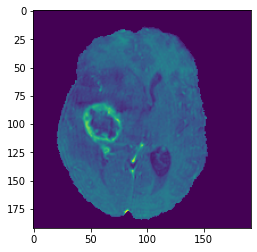

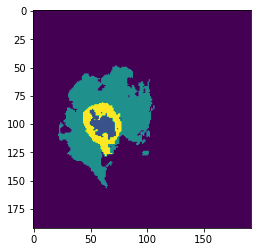

In [22]:
plt.imshow(data[42,:,:,2])
plt.show()
plt.imshow(gt[42,:,:])
plt.show()

In [23]:
gt[np.where(gt==4)]=3   #converting ground truth value of 4 to 3 => one hot encoding

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(data, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42) 

In [25]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [26]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((2700, 192, 192, 4),
 (2700, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 1))

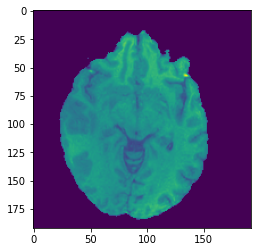

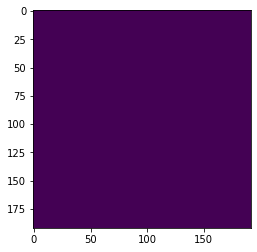

In [27]:
plt.imshow(X_train[0,:,:,1])
plt.show()
plt.imshow(Y_train[0,:,:,1])
plt.show()

In [28]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((2700, 192, 192, 4),
 (2700, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 4))

In [29]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
  

## 2DV_NET MODEL

In [144]:
def resBlock(conv,stage,keep_prob,stage_num=5):
    inputs=conv
    
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
    conv_add=PReLU()(add([inputs,conv]))
    conv_drop=Dropout(keep_prob)(conv_add)
    
    if stage<stage_num:
        conv_downsample=PReLU()(BatchNormalization()(Conv2D(16*(2**stage), 2, strides=(2, 2),activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv_drop)))
        return conv_downsample,conv_add
    else:
        return conv_add,conv_add
        
def up_resBlock(forward_conv,input_conv,stage):
    conv=concatenate([forward_conv,input_conv],axis = -1)
  
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
    conv_add=PReLU()(add([input_conv,conv]))
    if stage>1:
        conv_upsample=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(stage-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(conv_add)))
        return conv_upsample
    else:
        return conv_add

def vnet(pretrained_weights = None,input_size = (192,192,4),num_class=1,is_training=True,stage_num=5,thresh=0.5):
    keep_prob = 0.1
    features=[]
    input_model = Input(input_size)
    x=PReLU()(BatchNormalization()(Conv2D(16, 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(input_model)))
    
    for s in range(1,stage_num+1):
        x,feature=resBlock(x,s,keep_prob,stage_num)
        features.append(feature)
        
    conv_up=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(s-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(x)))
    
    for d in range(stage_num-1,0,-1):
        conv_up=up_resBlock(features[d-1],conv_up,d)
    if num_class>1:
        conv_out=Conv2D(num_class, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    else:
        conv_out=Conv2D(num_class, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    
    
    
    
    model=Model(inputs=input_model,outputs=conv_out)    

    model.compile(optimizer = Nadam(lr = 2e-4),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model
model=vnet(input_size = (192,192,4),num_class=4,stage_num=5)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_134 (Conv2D)            (None, 192, 192, 16  1616        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_146 (Batch  (None, 192, 192, 16  64         ['conv2d_134[0][0]']             
 Normalization)                 )                                                           

                                                                                                  
 batch_normalization_154 (Batch  (None, 48, 48, 64)  256         ['conv2d_142[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 p_re_lu_198 (PReLU)            (None, 48, 48, 64)   147456      ['batch_normalization_154[0][0]']
                                                                                                  
 add_44 (Add)                   (None, 48, 48, 64)   0           ['p_re_lu_195[0][0]',            
                                                                  'p_re_lu_198[0][0]']            
                                                                                                  
 p_re_lu_199 (PReLU)            (None, 48, 48, 64)   147456      ['add_44[0][0]']                 
          

                                                                                                  
 batch_normalization_163 (Batch  (None, 24, 24, 128)  512        ['conv2d_transpose_15[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 p_re_lu_210 (PReLU)            (None, 24, 24, 128)  73728       ['batch_normalization_163[0][0]']
                                                                                                  
 concatenate_12 (Concatenate)   (None, 24, 24, 256)  0           ['p_re_lu_204[0][0]',            
                                                                  'p_re_lu_210[0][0]']            
                                                                                                  
 conv2d_151 (Conv2D)            (None, 24, 24, 128)  819328      ['concatenate_12[0][0]']         
          

 conv2d_157 (Conv2D)            (None, 96, 96, 32)   51232       ['concatenate_14[0][0]']         
                                                                                                  
 batch_normalization_172 (Batch  (None, 96, 96, 32)  128         ['conv2d_157[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 p_re_lu_221 (PReLU)            (None, 96, 96, 32)   294912      ['batch_normalization_172[0][0]']
                                                                                                  
 conv2d_158 (Conv2D)            (None, 96, 96, 32)   25632       ['p_re_lu_221[0][0]']            
                                                                                                  
 batch_normalization_173 (Batch  (None, 96, 96, 32)  128         ['conv2d_158[0][0]']             
 Normaliza

In [145]:
checkpointer = callbacks.ModelCheckpoint(filepath = 'vnet-weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

In [149]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=30,callbacks=[checkpointer],shuffle=True)

Epoch 1/30
338/338 [==============================] - 2089s 6s/step - loss: 0.2290 - dice_coef: 0.7710 - accuracy: 0.8976 - val_loss: 0.1290 - val_dice_coef: 0.8710 - val_accuracy: 0.9775
Epoch 2/30
338/338 [==============================] - 2123s 6s/step - loss: 0.0465 - dice_coef: 0.9535 - accuracy: 0.9822 - val_loss: 0.0323 - val_dice_coef: 0.9677 - val_accuracy: 0.9835
Epoch 3/30
338/338 [==============================] - 1927s 6s/step - loss: 0.0230 - dice_coef: 0.9770 - accuracy: 0.9851 - val_loss: 0.0241 - val_dice_coef: 0.9759 - val_accuracy: 0.9818
Epoch 4/30
338/338 [==============================] - 1904s 6s/step - loss: 0.0189 - dice_coef: 0.9811 - accuracy: 0.9843 - val_loss: 0.0162 - val_dice_coef: 0.9838 - val_accuracy: 0.9859
Epoch 5/30
338/338 [==============================] - 1900s 6s/step - loss: 0.0145 - dice_coef: 0.9855 - accuracy: 0.9870 - val_loss: 0.0145 - val_dice_coef: 0.9855 - val_accuracy: 0.9870
Epoch 6/30
338/338 [==============================] - 1898s 

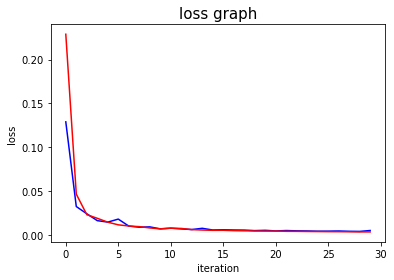

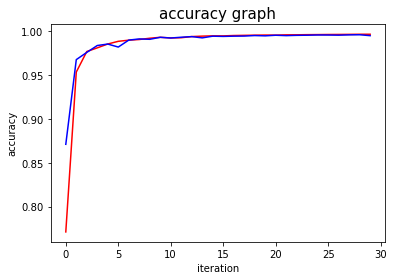

In [150]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [151]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

29/29 [==============================] - 117s 4s/step


In [152]:
np.unique(Y_pre)

array([0, 1, 2, 3], dtype=int64)

In [153]:
Y_pre.shape

(900, 192, 192)

In [154]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [155]:
Y_test.shape,X_test.shape

((900, 192, 192, 1), (900, 192, 192, 4))

X_test 0


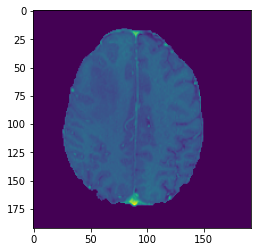

Predicted 0


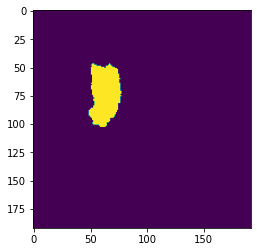

Actual 0


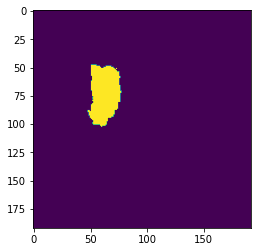

X_test 1


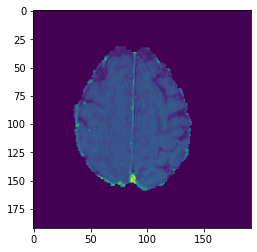

Predicted 1


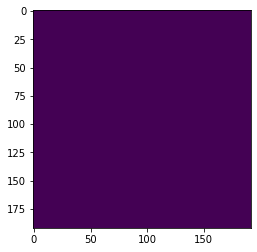

Actual 1


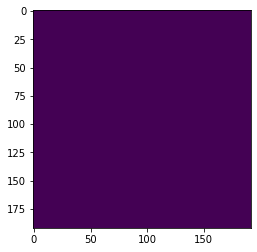

X_test 2


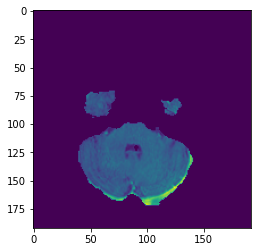

Predicted 2


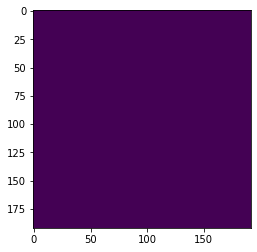

Actual 2


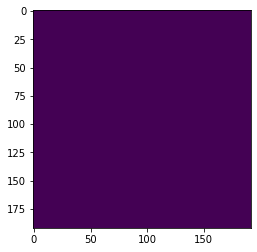

X_test 3


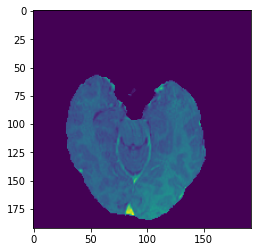

Predicted 3


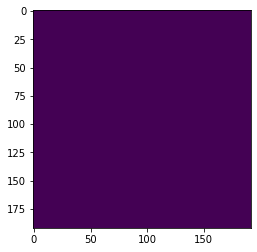

Actual 3


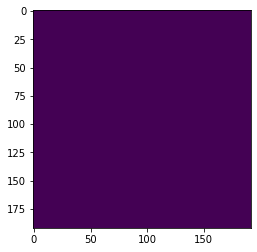

X_test 4


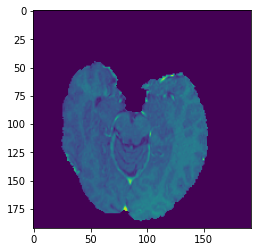

Predicted 4


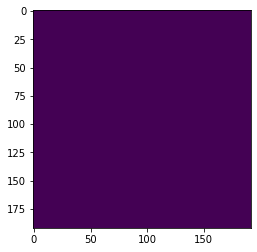

Actual 4


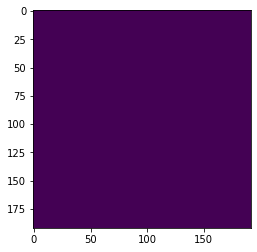

X_test 5


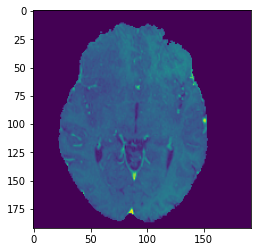

Predicted 5


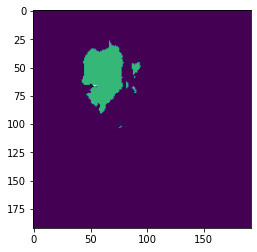

Actual 5


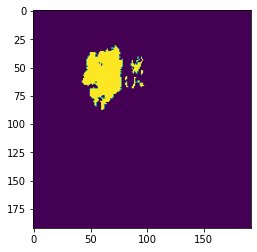

X_test 6


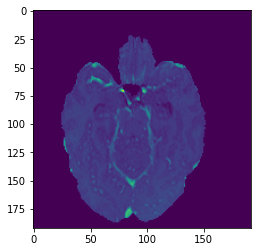

Predicted 6


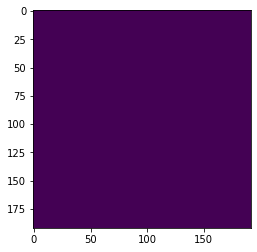

Actual 6


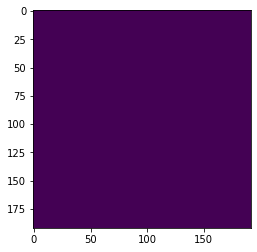

X_test 7


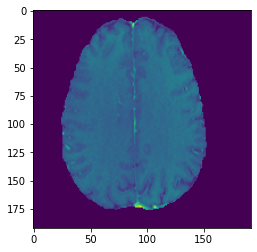

Predicted 7


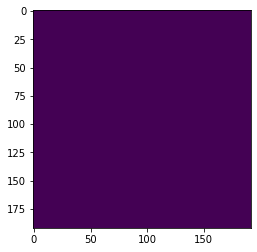

Actual 7


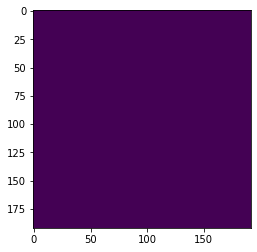

X_test 8


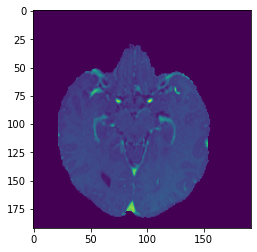

Predicted 8


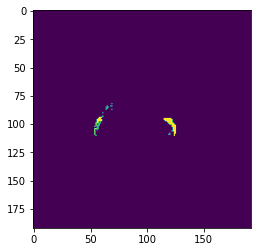

Actual 8


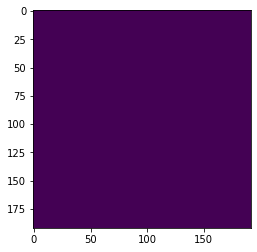

X_test 9


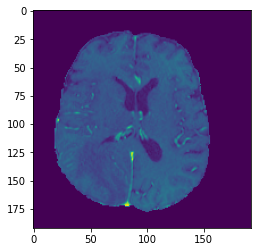

Predicted 9


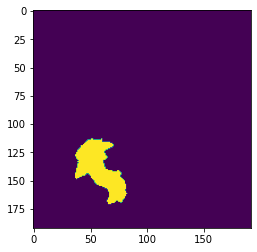

Actual 9


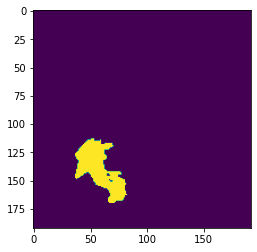

X_test 10


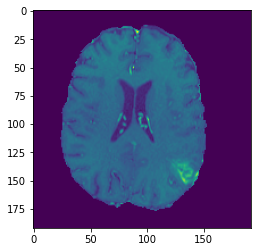

Predicted 10


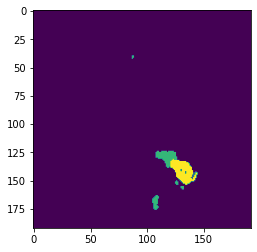

Actual 10


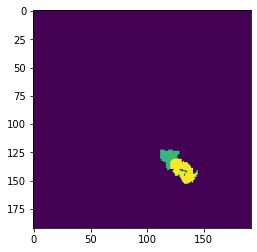

X_test 11


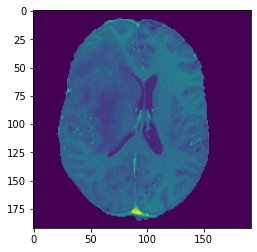

Predicted 11


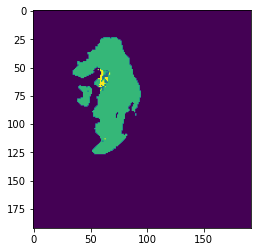

Actual 11


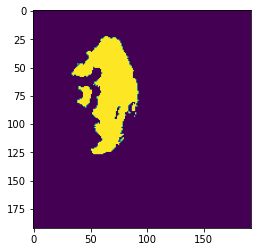

X_test 12


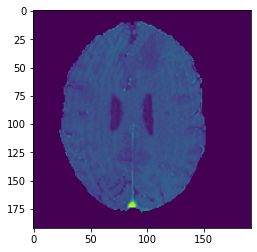

Predicted 12


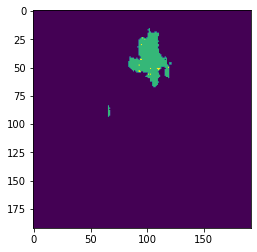

Actual 12


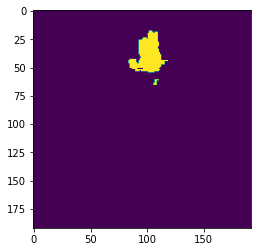

X_test 13


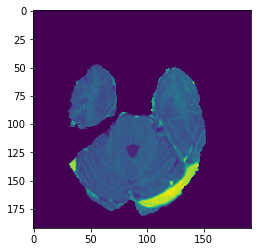

Predicted 13


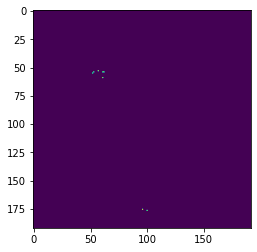

Actual 13


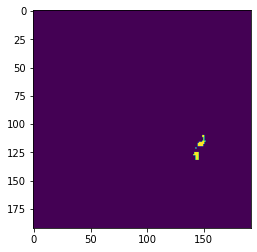

X_test 14


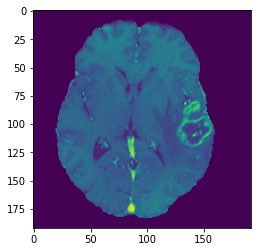

Predicted 14


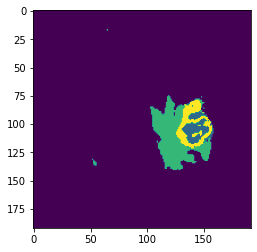

Actual 14


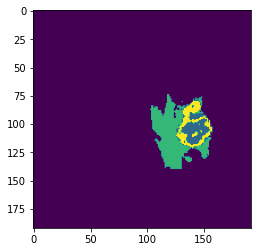

X_test 15


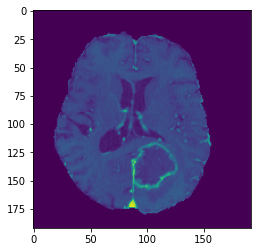

Predicted 15


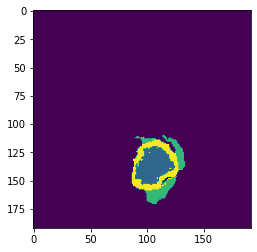

Actual 15


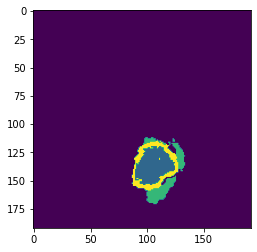

X_test 16


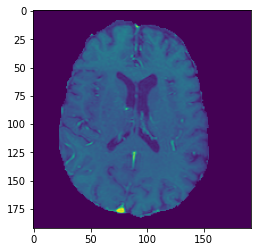

Predicted 16


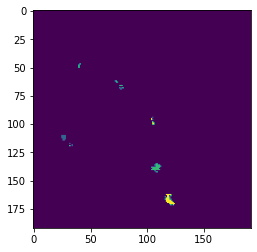

Actual 16


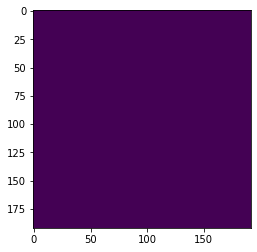

X_test 17


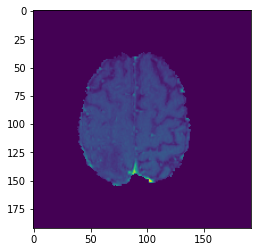

Predicted 17


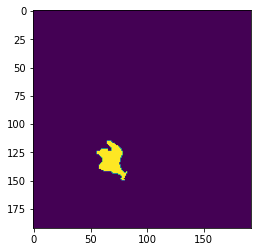

Actual 17


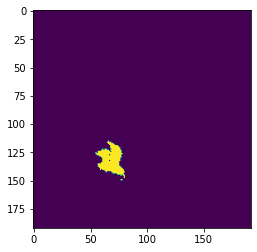

X_test 18


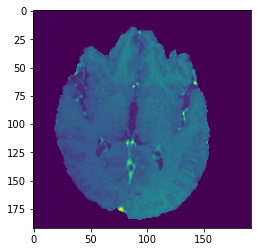

Predicted 18


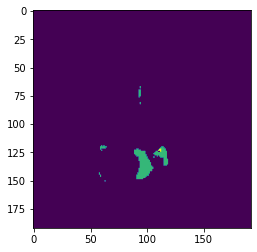

Actual 18


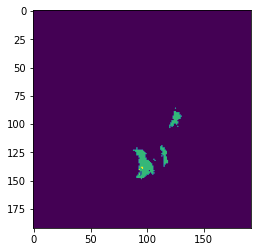

X_test 19


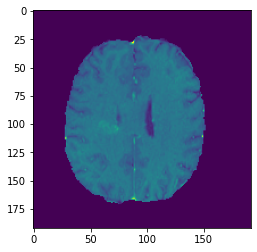

Predicted 19


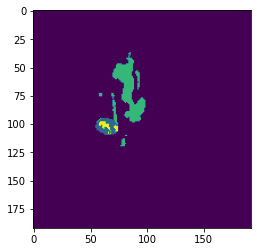

Actual 19


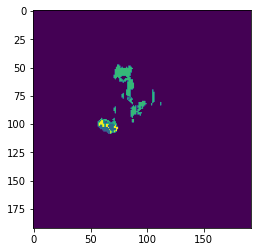

In [165]:
for i in range(20):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [157]:
Y_test_encod = to_categorical(Y_test)

In [158]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

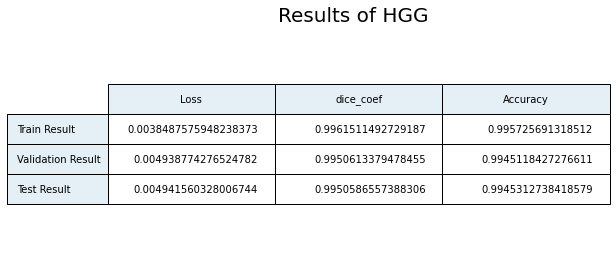

In [159]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

In [160]:
model.save('vnet-model.h5',overwrite=True)

## U_NET MODEL

In [29]:
#encoder

inputs = Input(shape=(192,192,4),name='input')  

block0_conv1 = Conv2D(32,3,padding='same',activation='relu',name='block0_conv1')(inputs)
block0_conv2 = Conv2D(32,3,padding='same',activation='relu',name='block0_conv2')(block0_conv1)
block0_norm = BatchNormalization(name='block0_batch_norm')(block0_conv2)
block0_pool = MaxPooling2D(name='block0_pool')(block0_norm)

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(block0_pool)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_conv1)
block1_norm = BatchNormalization(name='block1_batch_norm')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_conv1)
block2_norm = BatchNormalization(name='block2_batch_norm')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_conv1)
block3_norm = BatchNormalization(name='block3_batch_norm')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_conv1)
block4_norm = BatchNormalization(name='block4_batch_norm')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)

#decoder
up_pool1 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = Add()([block4_norm,up_pool1])
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = Add()([block3_norm,up_pool2])
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = Add()([block2_norm,up_pool3])
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = Add()([block1_norm,up_pool4])
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

up_pool5 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool5')(decod_block4_conv1)
merged_block5 = Add()([block0_norm,up_pool5])
decod_block5_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block5_conv1')(merged_block5)

pre_output = Conv2D(64,1,padding = 'same',activation='relu',name='pre_output')(decod_block5_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model = Model(inputs = inputs, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 block0_conv1 (Conv2D)          (None, 192, 192, 32  1184        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block0_conv2 (Conv2D)          (None, 192, 192, 32  9248        ['block0_conv1[0][0]']           
                                )                                                             

                                                                  'up_pool4[0][0]']               
                                                                                                  
 decod_block4_conv1 (Conv2D)    (None, 96, 96, 64)   36928       ['add_3[0][0]']                  
                                                                                                  
 up_pool5 (Conv2DTranspose)     (None, 192, 192, 32  18464       ['decod_block4_conv1[0][0]']     
                                )                                                                 
                                                                                                  
 add_4 (Add)                    (None, 192, 192, 32  0           ['block0_batch_norm[0][0]',      
                                )                                 'up_pool5[0][0]']               
                                                                                                  
 decod_blo

In [30]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model.save_weights('unet-weights.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = 'unet-weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

C:\Users\mrsci\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=30,callbacks=[checkpointer],shuffle=True)

Epoch 1/30
338/338 [==============================] - 1141s 3s/step - loss: 0.1525 - dice_coef: 0.8475 - accuracy: 0.9451 - val_loss: 0.0393 - val_dice_coef: 0.9607 - val_accuracy: 0.9759
Epoch 2/30
338/338 [==============================] - 1137s 3s/step - loss: 0.0240 - dice_coef: 0.9760 - accuracy: 0.9761 - val_loss: 0.0246 - val_dice_coef: 0.9754 - val_accuracy: 0.9759
Epoch 3/30
338/338 [==============================] - 1134s 3s/step - loss: 0.0239 - dice_coef: 0.9761 - accuracy: 0.9761 - val_loss: 0.0241 - val_dice_coef: 0.9759 - val_accuracy: 0.9759
Epoch 4/30
338/338 [==============================] - 1129s 3s/step - loss: 0.0239 - dice_coef: 0.9761 - accuracy: 0.9761 - val_loss: 0.0241 - val_dice_coef: 0.9759 - val_accuracy: 0.9759
Epoch 5/30
338/338 [==============================] - 1150s 3s/step - loss: 0.0239 - dice_coef: 0.9761 - accuracy: 0.9761 - val_loss: 0.0241 - val_dice_coef: 0.9759 - val_accuracy: 0.9759
Epoch 6/30
338/338 [==============================] - 1238s 

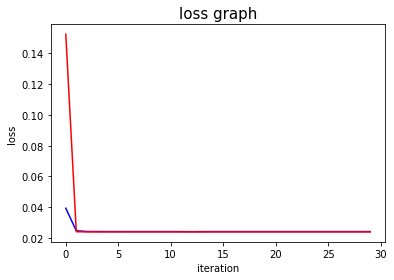

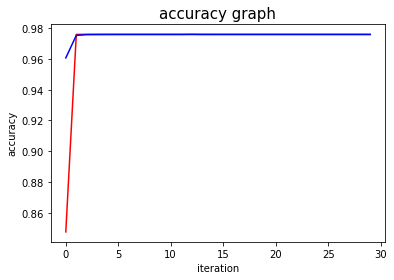

In [32]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [33]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

29/29 [==============================] - 88s 3s/step


In [34]:
np.unique(Y_pre)

array([0], dtype=int64)

In [35]:
Y_pre.shape

(900, 192, 192)

In [36]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [37]:
Y_test.shape,X_test.shape

((900, 192, 192, 1), (900, 192, 192, 4))

X_test 10


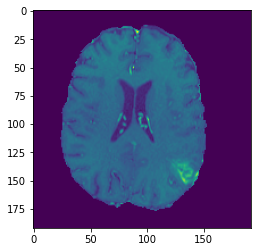

Predicted 10


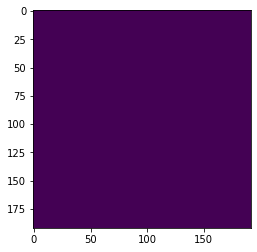

Actual 10


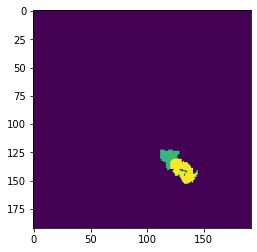

X_test 11


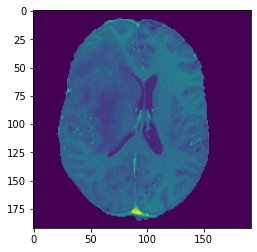

Predicted 11


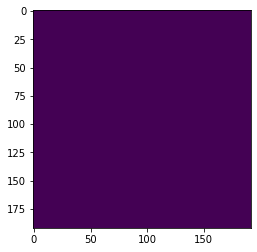

Actual 11


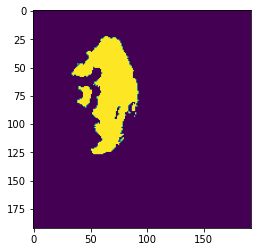

X_test 12


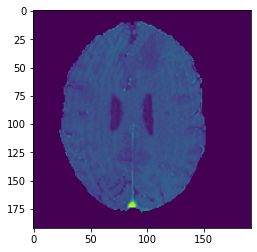

Predicted 12


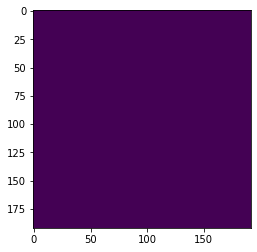

Actual 12


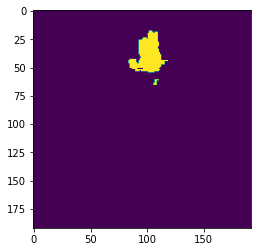

X_test 13


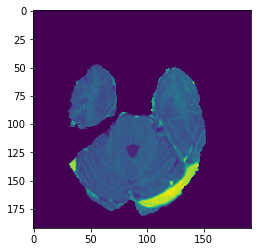

Predicted 13


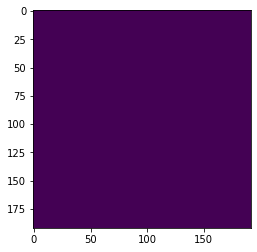

Actual 13


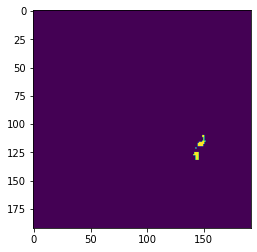

X_test 14


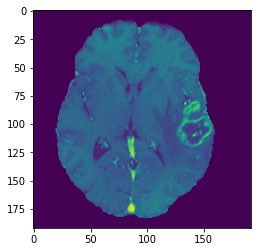

Predicted 14


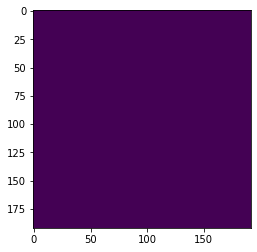

Actual 14


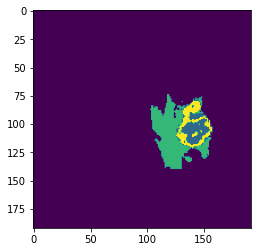

X_test 15


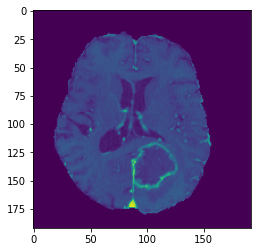

Predicted 15


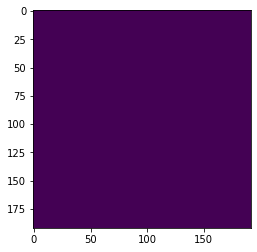

Actual 15


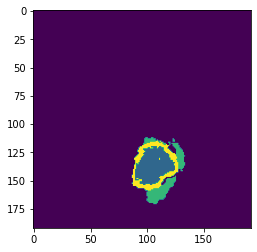

X_test 16


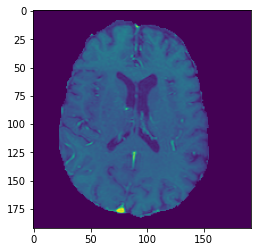

Predicted 16


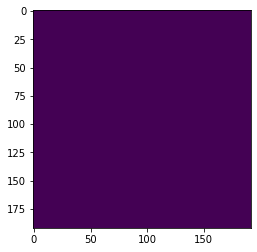

Actual 16


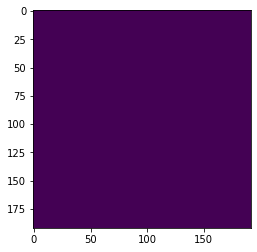

X_test 17


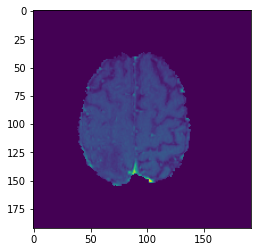

Predicted 17


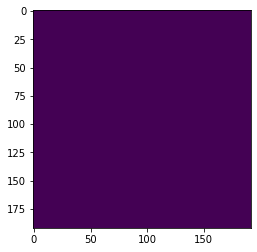

Actual 17


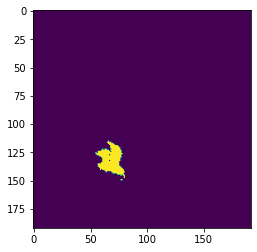

X_test 18


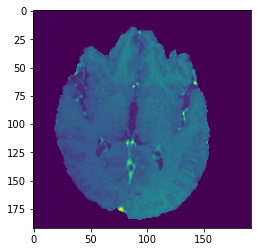

Predicted 18


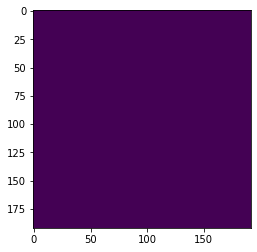

Actual 18


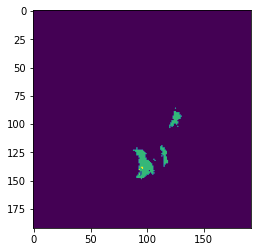

X_test 19


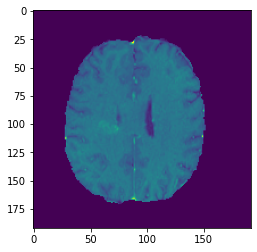

Predicted 19


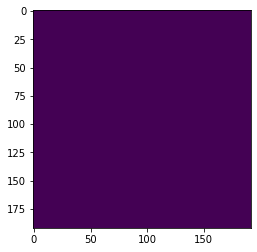

Actual 19


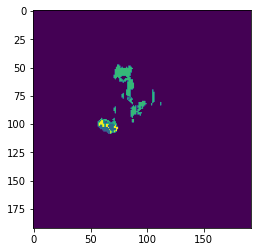

In [38]:
for i in range(10,20):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [39]:
Y_test_encod = to_categorical(Y_test)

In [40]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

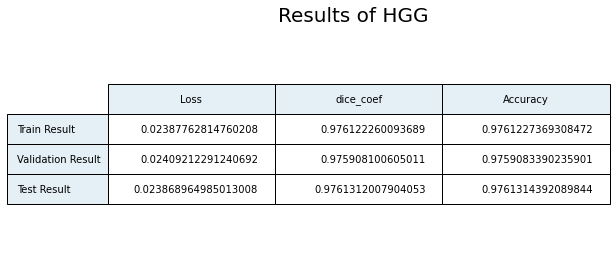

In [41]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

In [42]:
Y_pre.shape

(900, 192, 192, 1)

In [44]:
model.save('unet-model.h5',overwrite=True)

## UNET_MODEL_WITH_SOBEL_OPERATOR


In [30]:
wdata = np.zeros_like(data)

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement opevcv-python (from versions: none)
ERROR: No matching distribution found for opevcv-python


In [31]:
from skimage.segmentation import watershed
import cv2

def sobel(img):
  Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  img_sobelx = cv2.Sobel(img, cv2.CV_8U,1,0,ksize=3)
  img_sobely = cv2.Sobel(img, cv2.CV_8U,0,1,ksize=3)
  img_sobel = img_sobelx + img_sobely+img
  return img_sobel

(-0.5, 191.5, 191.5, -0.5)

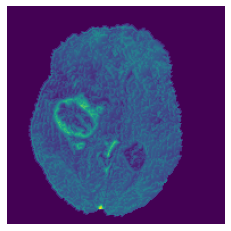

In [32]:
plt.imshow(sobel(data[40, :, :, 2]))
plt.axis("off")

In [33]:
for i in range(len(data)):
  for j in range(4):
    wdata[i,:,:,j] = sobel(data[i,:,:,j])

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(wdata, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [35]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [36]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((2700, 192, 192, 4),
 (2700, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 1))

In [37]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((2700, 192, 192, 4),
 (2700, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 4))

In [38]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [39]:
#encoder

inputs = Input(shape=(192,192,4),name='input')                                              

block0_conv1 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv1')(inputs)
block0_norm1 = BatchNormalization(name='block0_batch_norm1')(block0_conv1)
block0_conv2 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv2')(block0_norm1)
block0_norm2 = BatchNormalization(name='block0_batch_norm2')(block0_conv2)
block0_pool = MaxPooling2D(name='block0_pool')(block0_norm2)

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(block0_pool)
block1_norm1 = BatchNormalization(name='block1_batch_norm1')(block1_conv1)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_norm1)
block1_norm2 = BatchNormalization(name='block1_batch_norm2')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm2)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_norm1 = BatchNormalization(name='block2_batch_norm1')(block2_conv1)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_norm1)
block2_norm2 = BatchNormalization(name='block2_batch_norm2')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm2)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_norm1 = BatchNormalization(name='block3_batch_norm1')(block3_conv1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_norm1)
block3_norm2 = BatchNormalization(name='block3_batch_norm2')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm2)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_norm1 = BatchNormalization(name='block4_batch_norm1')(block4_conv1)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_norm1)
block4_norm2 = BatchNormalization(name='block4_batch_norm2')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm2)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)

#decoder
up_pool1 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = Add()([block4_norm1, block4_norm2, up_pool1])
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = Add()([block3_norm1, block3_norm2, up_pool2])
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = Add()([block2_norm1, block2_norm2 ,up_pool3])
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = Add()([block1_norm1, block1_norm1, up_pool4])
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

up_pool5 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool5')(decod_block4_conv1)
merged_block5 = Add()([block0_norm1, block0_norm2 ,up_pool5])
decod_block5_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block5_conv1')(merged_block5)

pre_output = Conv2D(32,1,padding = 'same',activation='relu',name='pre_output')(decod_block5_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model = Model(inputs = inputs, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 block0_conv1 (Conv2D)          (None, 192, 192, 32  1184        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block0_batch_norm1 (BatchNorma  (None, 192, 192, 32  128        ['block0_conv1[0][0]']           
 lization)                      )                                                             

                                                                  'block3_batch_norm2[0][0]',     
                                                                  'up_pool2[0][0]']               
                                                                                                  
 decod_block2_conv1 (Conv2D)    (None, 24, 24, 256)  590080      ['add_1[0][0]']                  
                                                                                                  
 decoder_dropout_1 (Dropout)    (None, 24, 24, 256)  0           ['decod_block2_conv1[0][0]']     
                                                                                                  
 up_pool3 (Conv2DTranspose)     (None, 48, 48, 128)  295040      ['decoder_dropout_1[0][0]']      
                                                                                                  
 add_2 (Add)                    (None, 48, 48, 128)  0           ['block2_batch_norm1[0][0]',     
          

In [40]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model.save_weights('weights.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = 'weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

C:\Users\mrsci\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [41]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=30,callbacks=[checkpointer],shuffle=True)

Epoch 1/30
338/338 [==============================] - 1223s 4s/step - loss: 0.2172 - dice_coef: 0.7828 - accuracy: 0.8055 - val_loss: 0.0277 - val_dice_coef: 0.9723 - val_accuracy: 0.9736
Epoch 2/30
338/338 [==============================] - 1194s 4s/step - loss: 0.0260 - dice_coef: 0.9740 - accuracy: 0.9741 - val_loss: 0.0261 - val_dice_coef: 0.9739 - val_accuracy: 0.9740
Epoch 3/30
338/338 [==============================] - 1175s 3s/step - loss: 0.0254 - dice_coef: 0.9746 - accuracy: 0.9746 - val_loss: 0.0248 - val_dice_coef: 0.9752 - val_accuracy: 0.9753
Epoch 4/30
338/338 [==============================] - 1171s 3s/step - loss: 0.0246 - dice_coef: 0.9754 - accuracy: 0.9755 - val_loss: 0.0248 - val_dice_coef: 0.9752 - val_accuracy: 0.9753
Epoch 5/30
338/338 [==============================] - 1169s 3s/step - loss: 0.0245 - dice_coef: 0.9755 - accuracy: 0.9755 - val_loss: 0.0247 - val_dice_coef: 0.9753 - val_accuracy: 0.9753
Epoch 6/30
338/338 [==============================] - 1186s 

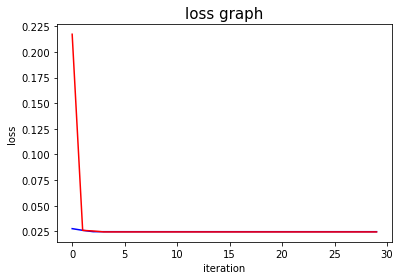

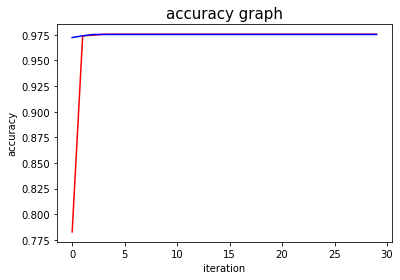

In [42]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [43]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

29/29 [==============================] - 84s 3s/step


In [44]:
np.unique(Y_pre)

array([0, 1], dtype=int64)

In [45]:
Y_pre.shape

(900, 192, 192)

In [46]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [47]:
Y_test.shape,X_test.shape

((900, 192, 192, 1), (900, 192, 192, 4))

X_test 10


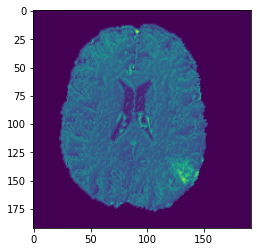

Predicted 10


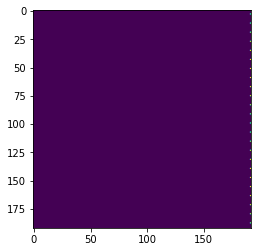

Actual 10


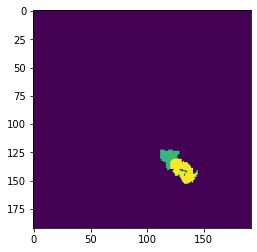

X_test 11


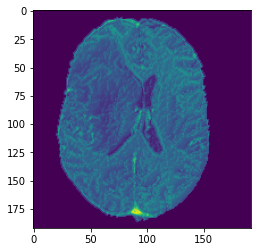

Predicted 11


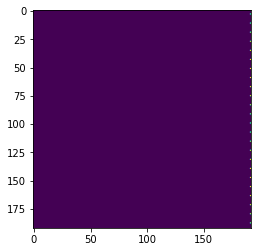

Actual 11


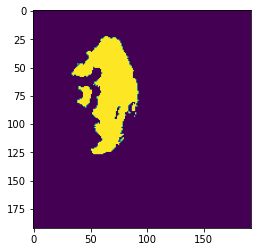

X_test 12


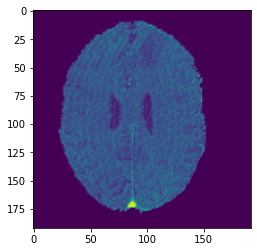

Predicted 12


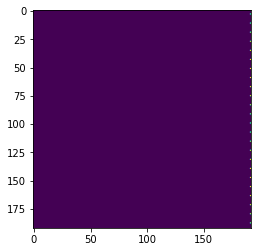

Actual 12


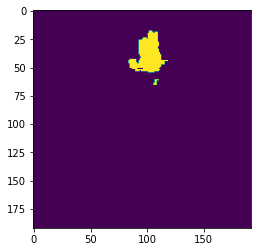

X_test 13


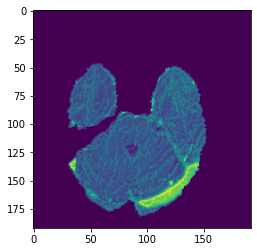

Predicted 13


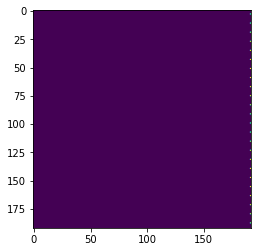

Actual 13


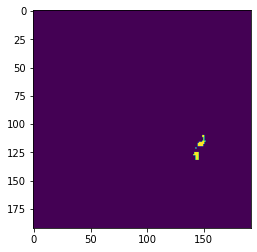

X_test 14


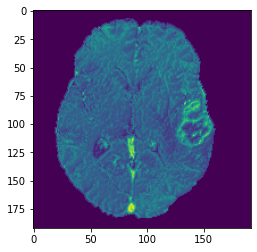

Predicted 14


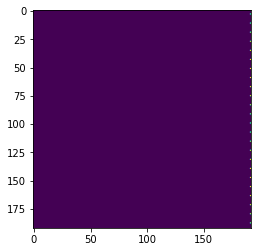

Actual 14


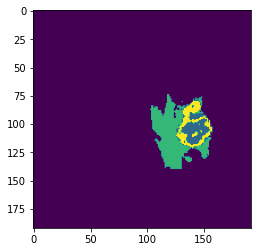

X_test 15


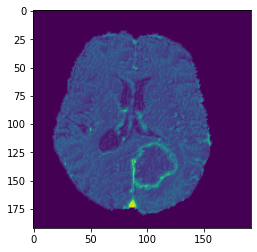

Predicted 15


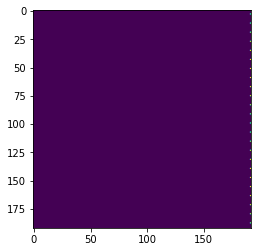

Actual 15


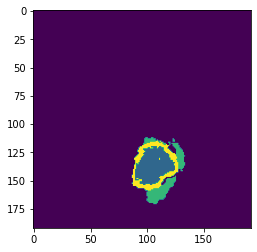

X_test 16


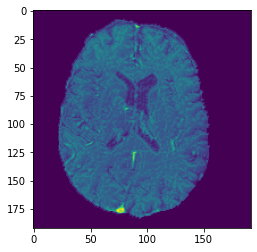

Predicted 16


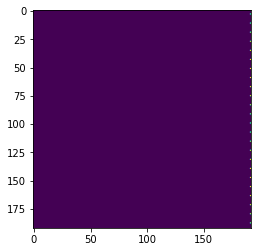

Actual 16


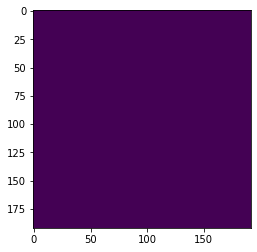

X_test 17


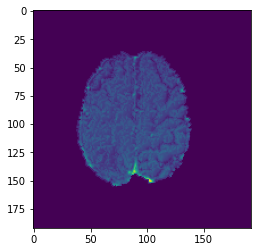

Predicted 17


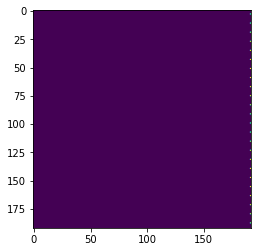

Actual 17


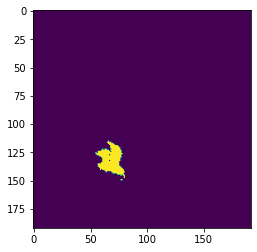

X_test 18


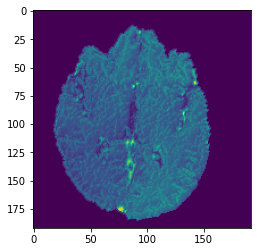

Predicted 18


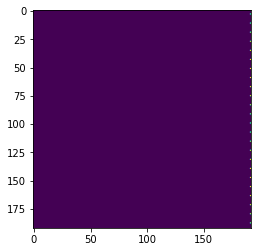

Actual 18


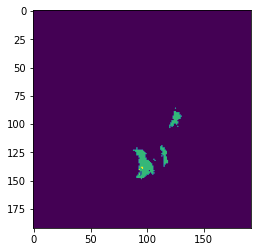

X_test 19


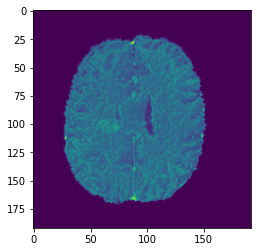

Predicted 19


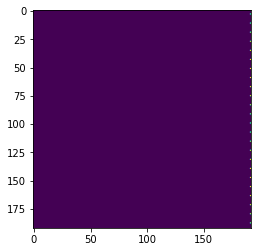

Actual 19


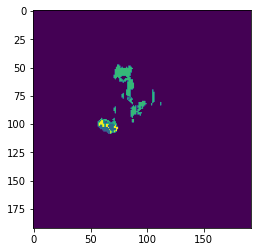

In [48]:
for i in range(10,20):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [49]:
Y_test_encod = to_categorical(Y_test)

In [52]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

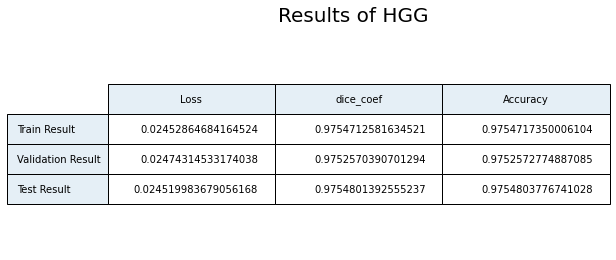

In [53]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

In [54]:
model.save("mod-unet-with-sobel.hdf5")

## WNET_MODEL

In [55]:
#encoder

inputs = Input(shape=(192,192,4),name='input')                                              

block0_conv1 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv1')(inputs)
block0_norm1 = BatchNormalization(name='block0_batch_norm1')(block0_conv1)
block0_conv2 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv2')(block0_norm1)
block0_norm2 = BatchNormalization(name='block0_batch_norm2')(block0_conv2)
block0_pool = MaxPooling2D(name='block0_pool')(block0_norm2)

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(block0_pool)
block1_norm1 = BatchNormalization(name='block1_batch_norm1')(block1_conv1)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_norm1)
block1_norm2 = BatchNormalization(name='block1_batch_norm2')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm2)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_norm1 = BatchNormalization(name='block2_batch_norm1')(block2_conv1)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_norm1)
block2_norm2 = BatchNormalization(name='block2_batch_norm2')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm2)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_norm1 = BatchNormalization(name='block3_batch_norm1')(block3_conv1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_norm1)
block3_norm2 = BatchNormalization(name='block3_batch_norm2')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm2)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_norm1 = BatchNormalization(name='block4_batch_norm1')(block4_conv1)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_norm1)
block4_norm2 = BatchNormalization(name='block4_batch_norm2')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm2)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)

#decoder
up_pool1 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = Add()([block4_norm1, block4_norm2, up_pool1])
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = Add()([block3_norm1, block3_norm2,up_pool2])
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = Add()([block2_norm1, block2_norm2 ,up_pool3])
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = Add()([block1_norm1, block1_norm1, up_pool4])
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

up_pool5 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool5')(decod_block4_conv1)
merged_block5 = Add()([block0_norm1, block0_norm2 ,up_pool5])
decod_block5_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block5_conv1')(merged_block5)

#encoder
block6_conv1 = Conv2D(32, 3,padding='same',activation='relu',name='block6_conv1')(decod_block5_conv1)
block6_norm1 = BatchNormalization(name='block6_batch_norm1')(block6_conv1)
block6_conv2 = Conv2D(32, 3,padding='same',activation='relu',name='block6_conv2')(block6_norm1)
block6_norm2 = BatchNormalization(name='block6_batch_norm2')(block6_conv2)
block6_pool = MaxPooling2D(name='block6_pool')(block6_norm2)

block7_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block7_conv1')(block6_pool)
block7_norm1 = BatchNormalization(name='block7_batch_norm1')(block7_conv1)
block7_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block7_conv2')(block7_norm1)
block7_norm2 = BatchNormalization(name='block7_batch_norm2')(block7_conv2)
block7_pool = MaxPooling2D(name='block7_pool')(block7_norm2)

block8_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block8_conv1')(block7_pool)
block8_norm1 = BatchNormalization(name='block8_batch_norm1')(block8_conv1)
block8_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block8_conv2')(block8_norm1)
block8_norm2 = BatchNormalization(name='block8_batch_norm2')(block8_conv2)
block8_pool = MaxPooling2D(name='block8_pool')(block8_norm2)

encoder_dropout_2 = Dropout(0.2,name='encoder_dropout_2')(block8_pool)

block9_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block9_conv1')(encoder_dropout_2)
block9_norm1 = BatchNormalization(name='block9_batch_norm1')(block9_conv1)
block9_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block9_conv2')(block9_norm1)
block9_norm2 = BatchNormalization(name='block9_batch_norm2')(block9_conv2)
block9_pool = MaxPooling2D(name='block9_pool')(block9_norm2)

block10_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block10_conv1')(block9_pool)
block10_norm1 = BatchNormalization(name='block10_batch_norm1')(block10_conv1)
block10_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block10_conv2')(block10_norm1)
block10_norm2 = BatchNormalization(name='block10_batch_norm2')(block10_conv2)
block10_pool = MaxPooling2D(name='block10_pool')(block10_norm2)

block11_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block11_conv1')(block10_pool)

#decoder
up_pool6 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool6')(block11_conv1)
merged_block6 = Add()([block10_norm1, block10_norm2, up_pool6])
decod_block6_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block6_conv1')(merged_block6)

up_pool7 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool7')(decod_block6_conv1)
merged_block7 = Add()([block9_norm1, block9_norm2,up_pool7])
decod_block7_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block7_conv1')(merged_block7)

decoder_dropout_2 = Dropout(0.2,name='decoder_dropout_2')(decod_block7_conv1)

up_pool8 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool8')(decoder_dropout_2)
merged_block8 = Add()([block8_norm1, block8_norm2 ,up_pool8])
decod_block8_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block8_conv1')(merged_block8)

up_pool9 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool9')(decod_block8_conv1)
merged_block9 = Add()([block7_norm1, block7_norm1, up_pool9])
decod_block9_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block9_conv1')(merged_block9)

up_pool10 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool10')(decod_block9_conv1)
merged_block10 = Add()([block6_norm1, block6_norm2 ,up_pool10])
decod_block10_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block10_conv1')(merged_block10)




pre_output = Conv2D(32,1,padding = 'same',activation='relu',name='pre_output')(decod_block10_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model = Model(inputs = inputs, outputs = output)
model.summary()
     

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 block0_conv1 (Conv2D)          (None, 192, 192, 32  1184        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block0_batch_norm1 (BatchNorma  (None, 192, 192, 32  128        ['block0_conv1[0][0]']           
 lization)                      )                                                           

                                                                  'block3_batch_norm2[0][0]',     
                                                                  'up_pool2[0][0]']               
                                                                                                  
 decod_block2_conv1 (Conv2D)    (None, 24, 24, 256)  590080      ['add_6[0][0]']                  
                                                                                                  
 decoder_dropout_1 (Dropout)    (None, 24, 24, 256)  0           ['decod_block2_conv1[0][0]']     
                                                                                                  
 up_pool3 (Conv2DTranspose)     (None, 48, 48, 128)  295040      ['decoder_dropout_1[0][0]']      
                                                                                                  
 add_7 (Add)                    (None, 48, 48, 128)  0           ['block2_batch_norm1[0][0]',     
          

 block9_pool (MaxPooling2D)     (None, 12, 12, 256)  0           ['block9_batch_norm2[0][0]']     
                                                                                                  
 block10_conv1 (Conv2D)         (None, 12, 12, 512)  1180160     ['block9_pool[0][0]']            
                                                                                                  
 block10_batch_norm1 (BatchNorm  (None, 12, 12, 512)  2048       ['block10_conv1[0][0]']          
 alization)                                                                                       
                                                                                                  
 block10_conv2 (Conv2D)         (None, 12, 12, 512)  2359808     ['block10_batch_norm1[0][0]']    
                                                                                                  
 block10_batch_norm2 (BatchNorm  (None, 12, 12, 512)  2048       ['block10_conv2[0][0]']          
 alization

In [56]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model.save_weights('wnet-weights-n.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = 'wnet-weights-n.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

In [57]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=30,callbacks=[checkpointer],shuffle=True)

Epoch 1/30
338/338 [==============================] - 2381s 7s/step - loss: 0.2969 - dice_coef: 0.7031 - accuracy: 0.6765 - val_loss: 0.0261 - val_dice_coef: 0.9739 - val_accuracy: 0.9747
Epoch 2/30
338/338 [==============================] - 2435s 7s/step - loss: 0.0242 - dice_coef: 0.9758 - accuracy: 0.9759 - val_loss: 0.0242 - val_dice_coef: 0.9758 - val_accuracy: 0.9759
Epoch 3/30
338/338 [==============================] - 2463s 7s/step - loss: 0.0240 - dice_coef: 0.9761 - accuracy: 0.9761 - val_loss: 0.0241 - val_dice_coef: 0.9759 - val_accuracy: 0.9759
Epoch 4/30
338/338 [==============================] - 2395s 7s/step - loss: 0.0239 - dice_coef: 0.9761 - accuracy: 0.9761 - val_loss: 0.0241 - val_dice_coef: 0.9759 - val_accuracy: 0.9759
Epoch 5/30
338/338 [==============================] - 2275s 7s/step - loss: 0.0239 - dice_coef: 0.9761 - accuracy: 0.9761 - val_loss: 0.0241 - val_dice_coef: 0.9759 - val_accuracy: 0.9759
Epoch 6/30
338/338 [==============================] - 2274s 

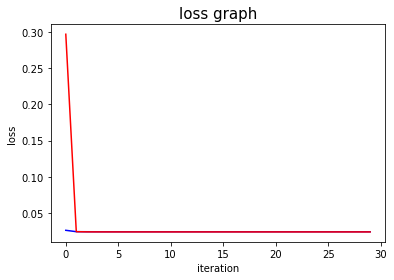

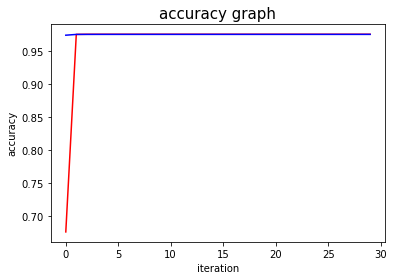

In [58]:
a = history.history

list_traindice = a['accuracy']
list_testdice = a['val_accuracy']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [59]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

29/29 [==============================] - 166s 6s/step


In [60]:
np.unique(Y_pre)

array([0], dtype=int64)

In [61]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [62]:
Y_test.shape,X_test.shape

((900, 192, 192, 1), (900, 192, 192, 4))

X_test 10


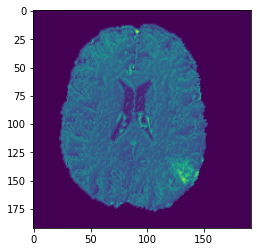

Predicted 10


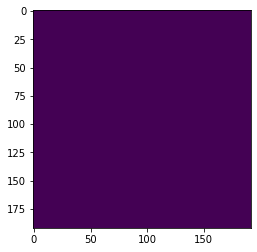

Actual 10


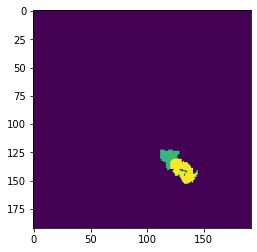

X_test 11


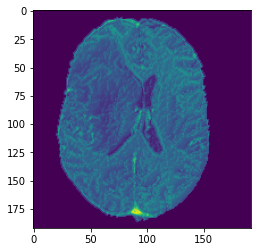

Predicted 11


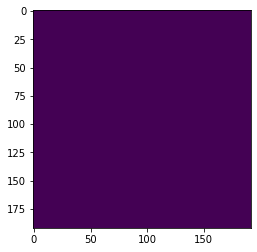

Actual 11


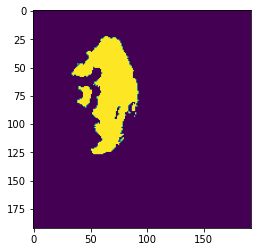

X_test 12


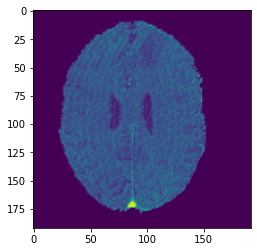

Predicted 12


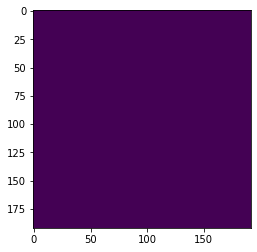

Actual 12


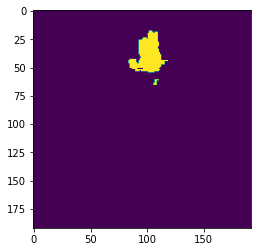

X_test 13


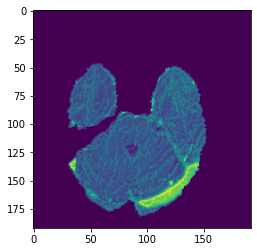

Predicted 13


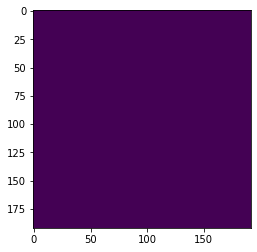

Actual 13


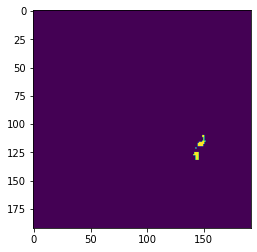

X_test 14


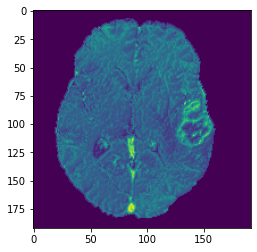

Predicted 14


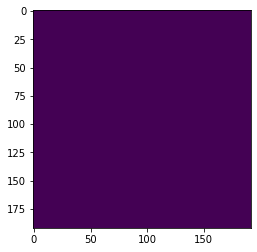

Actual 14


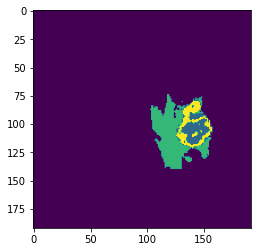

In [67]:
for i in range(10,15):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [64]:
Y_test_encod = to_categorical(Y_test)

In [65]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

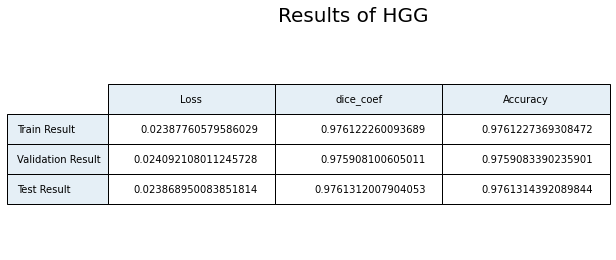

In [66]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

## END

In [68]:
model.save("mod-wnet.hdf5")